# Import Library

In [99]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

Kode diatas menunjukan library apa saja yang digunakan

# Load Dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizfajar28","key":"f7fd442caa4184f869b5a7fd161e6ddc"}'}

Kode diatas berfungsi untuk memasukkan file kaggle.json.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download vivekparasharr/recommender-system-e-commerce-dataset
!unzip recommender-system-e-commerce-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/vivekparasharr/recommender-system-e-commerce-dataset
License(s): apache-2.0
  0% 0.00/75.3k [00:00<?, ?B/s]
100% 75.3k/75.3k [00:00<00:00, 333MB/s]
Archive:  recommender-system-e-commerce-dataset.zip
  inflating: context.csv             
  inflating: interactions.csv        
  inflating: products.csv            
  inflating: reviews.csv             
  inflating: users.csv               


Kode diatas berfungsi untuk mengunduh dataset dari kaggle dan melakukan ekstraksi pada file yang di unduh. terdapat 4 dataset yaitu:
- context.csv
- interactions.csv
- products.csv
- reviews.csv
- users.csv

# Data Understanding

In [4]:
context = pd.read_csv('/content/context.csv')
interactions = pd.read_csv('/content/interactions.csv')
products = pd.read_csv('/content/products.csv')
reviews = pd.read_csv('/content/reviews.csv')
users = pd.read_csv('/content/users.csv')

In [5]:
print("Jumlah data Kontekstual:", len(context))
print("Jumlah data Interaksi:", len(interactions))
print("Jumlah data Produk:", len(products))
print("Jumlah data Ulasan:", len(reviews))
print("Jumlah data Pengguna:", len(users))

Jumlah data Kontekstual: 5000
Jumlah data Interaksi: 5000
Jumlah data Produk: 500
Jumlah data Ulasan: 2000
Jumlah data Pengguna: 1000


# Univariate Exploratory Data Analysis

Variabel-variabel pada E-commerce dataset adalah sebagai berikut:
- **context**: Data kontekstual seperti waktu dalam sehari, perangkat yang digunakan, dan lokasi pengguna.
- **interactions**: Interaksi pengguna dengan produk, seperti melihat produk, menambahkan ke keranjang, dan melakukan pembelian.
- **products**: Informasi detail mengenai produk, termasuk kategori, harga, dan merek.
- **reviews**: Ulasan produk dari pengguna, mencakup penilaian (rating) dan masukan dalam bentuk teks.
- **users**: Data demografis pengguna, seperti usia, jenis kelamin, dan lokasi.

## Context Variabel

In [6]:
context.head().T

,0,1,2,3,4
interaction_id,1,2,3,4,5
time_of_day,Evening,Evening,Morning,Evening,Night
device,Tablet,Mobile,Desktop,Tablet,Desktop
location,New York,San Francisco,New York,New York,Chicago


In [7]:
context.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   interaction_id  5000 non-null   int64 
 1   time_of_day     5000 non-null   object
 2   device          5000 non-null   object
 3   location        5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


Berdasarkan output diatas dapat diketahui bahwa variabel context memiliki:
- 5000 baris
- 4 kolom (interaction_id, time_of_day, device, location)
- Tipe data int untuk interaction_id, kolom lainnya bertipe object


### Melihat nilai unik

In [8]:
print('Jumlah interaction: ', len(context.interaction_id.unique()))
print('Waktu :', context.time_of_day.unique())
print('Perangkat :', context.device.unique())
print('Lokasi :', context.location.unique())

Jumlah interaction:  5000
Waktu : ['Evening' 'Morning' 'Night' 'Afternoon']
Perangkat : ['Tablet' 'Mobile' 'Desktop']
Lokasi : ['New York' 'San Francisco' 'Chicago' 'Los Angeles' 'Houston']


Berdasarkan output diatas dapat diketahui nilai unik pada waktu, perangkat dan lokasi.

### Visualisasi Data

In [9]:
def countplot(data, x, title):
  sns.countplot(data=data, x=x, order=data[x].value_counts().index, width=0.5)
  plt.title(title)
  plt.show()

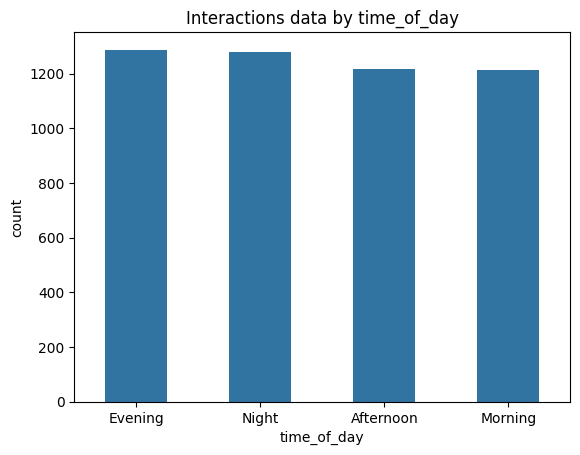

In [10]:
countplot(data=context, x='time_of_day', title="Interactions data by time_of_day")

Dari gambar diatas dapat diketahui bahwa interaksi paling banyak dilakukan pada waktu sore dan malam.

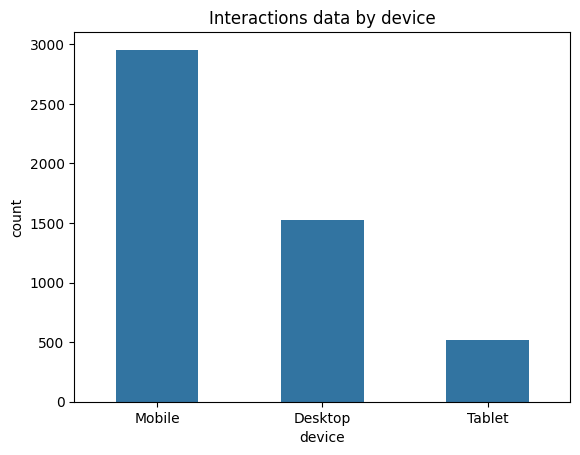

In [11]:
countplot(data=context, x='device', title="Interactions data by device")

Dari data diatas dapat diketahui bahwa interaksi paling banyak dilakukan melalui perangkat mobile.

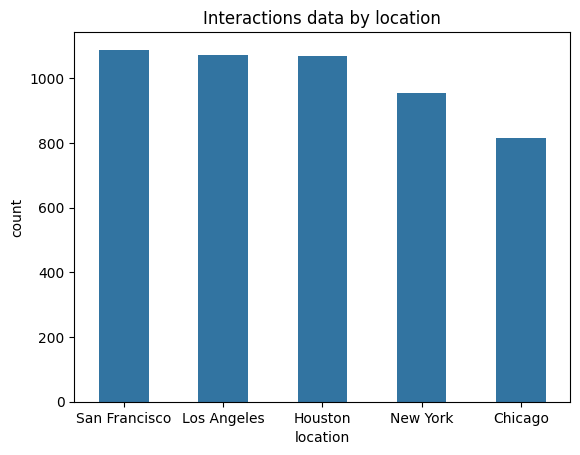

In [12]:
countplot(data=context, x='location', title="Interactions data by location")

Dari gambar diatas dapat diketahui bahwa lokasi dengan interaksi paling banyak adalah San Francisco dan Los Angeles.

## Interactions Variable

In [13]:
interactions.head().T

,0,1,2,3,4
user_id,869,368,429,830,807
product_id,22,463,269,412,161
interaction_type,purchase,view,view,view,add_to_cart
timestamp,2024-01-01 00:00:00,2024-01-01 01:00:00,2024-01-01 02:00:00,2024-01-01 03:00:00,2024-01-01 04:00:00


In [14]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           5000 non-null   int64 
 1   product_id        5000 non-null   int64 
 2   interaction_type  5000 non-null   object
 3   timestamp         5000 non-null   object
dtypes: int64(2), object(2)
memory usage: 156.4+ KB


Berdasarkan output diatas dapat diketahui bahwa variabel interactions memiliki:
- 5000 baris
- 4 kolom (user_id, product_id, interaction_type, timestamp)
- Tipe data int untuk id dan object untuk interaction_type dan timestamp

### Melihat nilai unik

In [15]:
print('Jumlah user: ', len(interactions.user_id.unique()))
print('Jumlah product: ', len(interactions.product_id.unique()))
print('Tipe interaksi :', interactions.interaction_type.unique())
print('Tanggal :', interactions.timestamp.unique())

Jumlah user:  996
Jumlah product:  500
Tipe interaksi : ['purchase' 'view' 'add_to_cart']
Tanggal : ['2024-01-01 00:00:00' '2024-01-01 01:00:00' '2024-01-01 02:00:00' ...
 '2024-07-27 05:00:00' '2024-07-27 06:00:00' '2024-07-27 07:00:00']


Berdasarkan output diatas dapat diketahui bahwa terdapat 996 pengguna unik dan 500 produk unik, dengan tiga jenis interaksi utama: view, add_to_cart, dan purchase. Data mencakup periode dari 1 Januari hingga 27 Juli 2024.

### Visualisasi Data

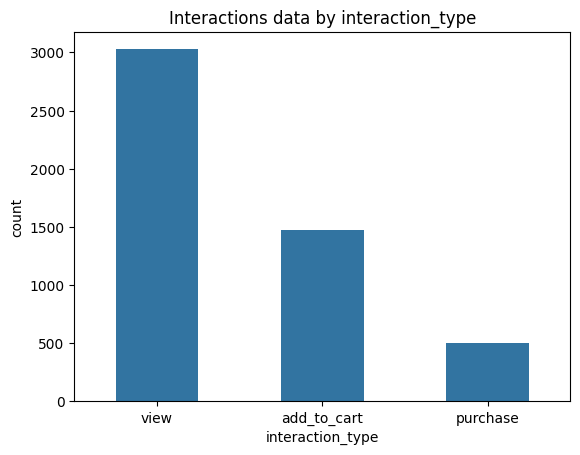

In [16]:
countplot(data=interactions, x='interaction_type', title="Interactions data by interaction_type")

Dari gambar diatas dapat diketahui distribusi interaction_type yang lebih didominasi oleh view.

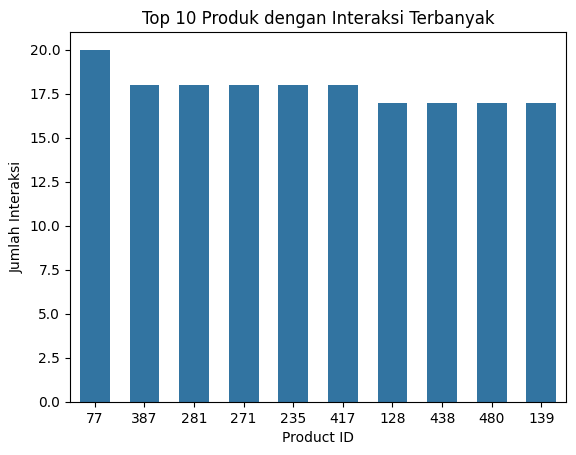

In [17]:
top_products = interactions['product_id'].value_counts().nlargest(10)

sns.barplot(x=top_products.index.astype(str), y=top_products.values, width=0.6)
plt.title('Top 10 Produk dengan Interaksi Terbanyak')
plt.xlabel('Product ID')
plt.ylabel('Jumlah Interaksi')
plt.show()

Dari gambar diatas dapat terlihat top 10 produk yang memiliki jumlah interaksi paling banyak.

## Products Variabel

In [18]:
products.head().T

,0,1,2,3,4
product_id,1,2,3,4,5
category,Home & Kitchen,Clothing,Sports,Electronics,Beauty
price,305.4,80.03,20.31,485.52,387.9
brand,BrandB,BrandB,BrandC,BrandB,BrandA


In [19]:
products.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,500.0,250.50000,144.481833,1.00,125.750,250.500,375.250,500.00
price,500.0,263.40714,143.523863,5.22,139.055,275.155,386.825,499.86


In [20]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  500 non-null    int64  
 1   category    500 non-null    object 
 2   price       500 non-null    float64
 3   brand       500 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 15.8+ KB


Berdasarkan output diatas dapat diketahui bahwa variabel products memiliki:
- 500 baris
- 4 kolom (product_id, category, price, brand)
- Tipe data int untuk id, float untuk price dan object untuk category dan brand

### Melihat nilai unik

In [21]:
print('Banyak data : ', len(products.product_id.unique()))
print('Kategori :', products.category.unique())
print('Merek :', products.brand.unique())

Banyak data :  500
Kategori : ['Home & Kitchen' 'Clothing' 'Sports' 'Electronics' 'Beauty' 'Books'
 'Toys']
Merek : ['BrandB' 'BrandC' 'BrandA' 'BrandD' 'BrandE']


Berdasarkan output diatas dapat diketahui bahwa produk terdiri dari 500 produk unik yang tersebar dalam 7 kategori, yaitu Home & Kitchen, Clothing, Sports, Electronics, Beauty, Books, dan Toys. Produk-produk ini berasal dari 5 merek berbeda, seperti BrandA hingga BrandE.

### Visualisasi data

In [22]:
def countplot_2(data, x, title, xlabel, ylabel, rotation):
  sns.countplot(data=data, x=x, order=data[x].value_counts().index, width=0.5)
  plt.title(title)
  plt.xticks(rotation=rotation)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.tight_layout()
  plt.show()

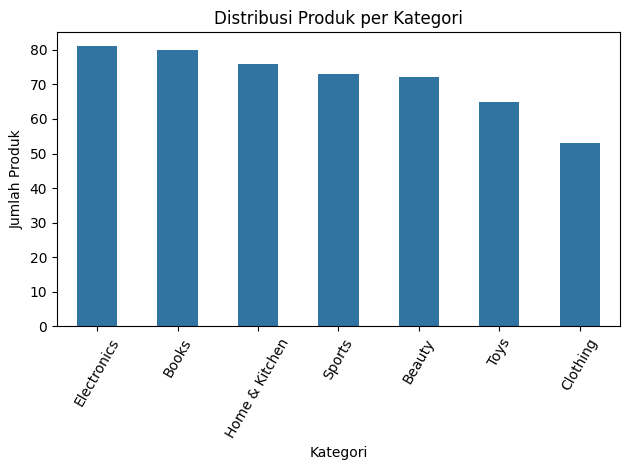

In [23]:
countplot_2(data=products, x='category', title='Distribusi Produk per Kategori', xlabel='Kategori', ylabel='Jumlah Produk', rotation=60)

Dari gambar diatas dapat diketahui distribusi produk berdasarkan kategori, yang didominasi oleh Electronics dan Books.

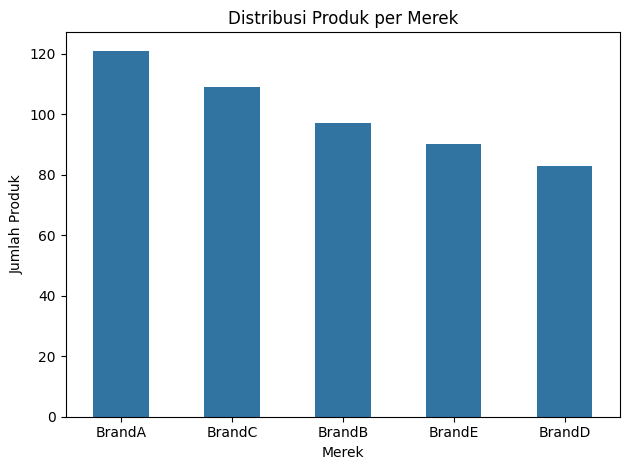

In [24]:
countplot_2(data=products, x='brand', title='Distribusi Produk per Merek', xlabel='Merek', ylabel='Jumlah Produk', rotation=0)

Dari gambar diatas dapat diketahui distribusi produk berdasarkan merek, yang dipimpin oleh BrandA dengan total 120 produk.

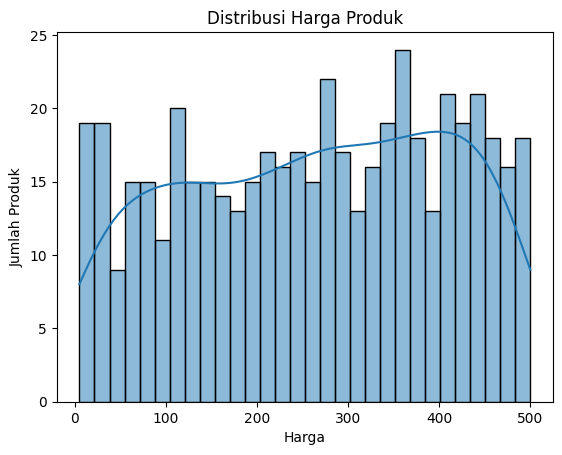

In [25]:
sns.histplot(data=products, x='price', bins=30, kde=True)
plt.title('Distribusi Harga Produk')
plt.xlabel('Harga')
plt.ylabel('Jumlah Produk')
plt.show()

Dari gambar diatas dapat diketahui distribusi produk berdasarkan harga, harga tertinggi adalah $500.

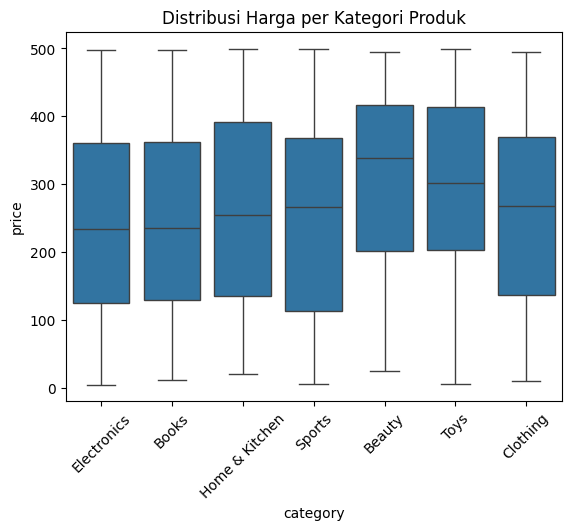

In [26]:
sns.boxplot(data=products, x='category', y='price', order=products['category'].value_counts().index)
plt.title('Distribusi Harga per Kategori Produk')
plt.xticks(rotation=45)
plt.show()

Dari gambar diatas dapat diketahui rentang harga tiap kategori produk.

## Reviews Variabel

In [27]:
reviews.head().T

,0,1,2,3,4
user_id,918,110,353,813,91
product_id,393,404,366,82,381
rating,4,3,5,1,4
review_text,Not worth the price.,Highly recommended!,Poor quality.,Great product!,Great product!


In [28]:
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2000.0,507.7790,285.451384,1.0,258.0,516.0,747.0,1000.0
product_id,2000.0,253.9415,143.697674,1.0,135.0,255.0,376.0,500.0
rating,2000.0,2.9475,1.399186,1.0,2.0,3.0,4.0,5.0


In [29]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      2000 non-null   int64 
 1   product_id   2000 non-null   int64 
 2   rating       2000 non-null   int64 
 3   review_text  2000 non-null   object
dtypes: int64(3), object(1)
memory usage: 62.6+ KB


Berdasarkan output diatas dapat diketahui bahwa reviews variabel memiliki:
- 2000 baris
- 4 kolom (user_id, product_id, rating dan review_text)
- tipe data review_text adalah object dan lainnya bertipe int

### Melihat jumlah data berdasarkan user_id dan produk_id

In [30]:
print('Jumlah user_id: ', len(reviews.user_id.unique()))
print('Jumlah product_id: ', len(reviews.product_id.unique()))

Jumlah user_id:  864
Jumlah product_id:  495


Berdasarkan output diatas dapat diketahui bahwa ulasan mencakup 864 pengguna unik yang memberikan penilaian terhadap 495 produk berbeda.

### Visualisasi Data

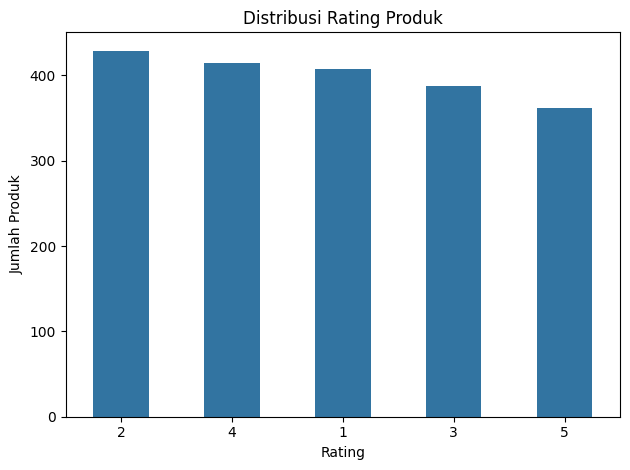

In [31]:
countplot_2(data=reviews, x='rating', title='Distribusi Rating Produk', xlabel='Rating', ylabel='Jumlah Produk', rotation=0)

Dari gambar diatas dapat diketahui distribusi rating produk, yang dipimpin oleh rating 2 dan 4.

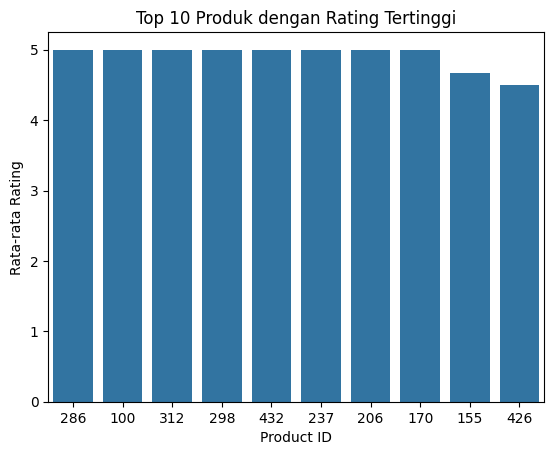

In [32]:
avg_rating = reviews.groupby('product_id')['rating'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=avg_rating.index.astype(str), y=avg_rating.values)
plt.title('Top 10 Produk dengan Rating Tertinggi')
plt.xlabel('Product ID')
plt.ylabel('Rata-rata Rating')
plt.show()

Dari gambar diatas dapat diketahui Rata-rata Rating per Produk (Top 10 Produk dengan Rating Tertinggi)

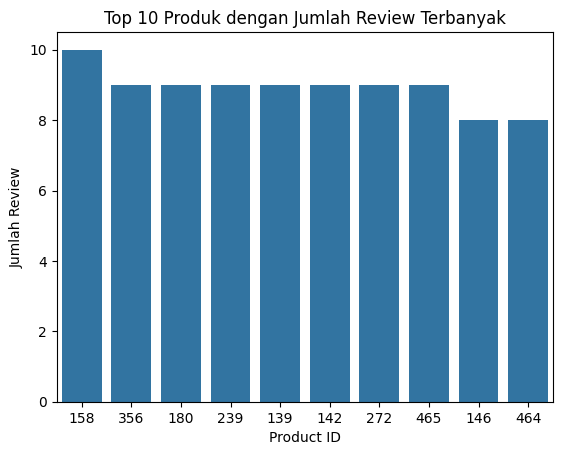

In [33]:
review_counts = reviews['product_id'].value_counts().nlargest(10)

sns.barplot(x=review_counts.index.astype(str), y=review_counts.values)
plt.title('Top 10 Produk dengan Jumlah Review Terbanyak')
plt.xlabel('Product ID')
plt.ylabel('Jumlah Review')
plt.show()

Dari gambar diatas dapat diketahui jumlah Review per Produk (Top 10 Produk Terbanyak Direview).

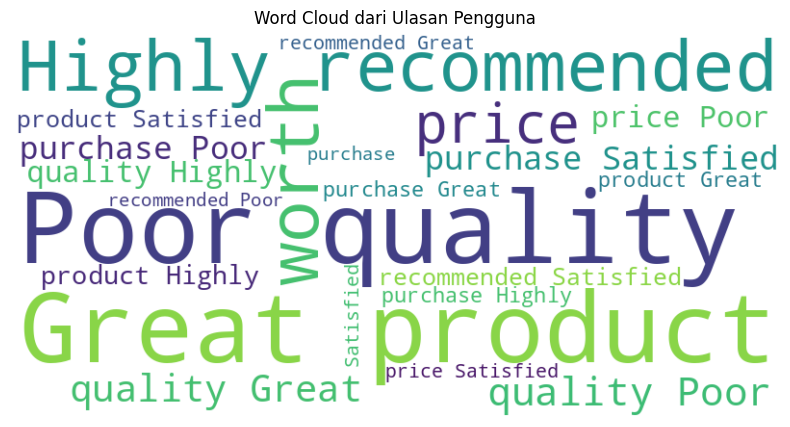

In [34]:
all_reviews = " ".join(reviews['review_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Ulasan Pengguna')
plt.show()

Dari gambar diatas dapat diketahui Word Cloud dari Review Text, plot ini biasa digunakan untuk analisis teks.

## Users Variabel

In [35]:
users.head().T

,0,1,2,3,4
user_id,1,2,3,4,5
age,56,46,32,60,25
gender,Male,Female,Male,Other,Male
location,San Francisco,Houston,Chicago,San Francisco,Los Angeles


In [36]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
age,1000.0,40.986,13.497852,18.0,29.00,42.0,52.00,64.0


In [37]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   1000 non-null   int64 
 1   age       1000 non-null   int64 
 2   gender    1000 non-null   object
 3   location  1000 non-null   object
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


Berdasarkan output diatas dapat diketahui bahwa users:
- 1000 baris
- 4 kolom (user_id, age, gender dan location)
- tipe data int untuk id dan age, object untuk gender dan location

### Melihat nilai unik

In [38]:
print('Jumlah gender: ', users.gender.unique())
print('Jumlah lokasi: ', users.location.unique())

Jumlah gender:  ['Male' 'Female' 'Other']
Jumlah lokasi:  ['San Francisco' 'Houston' 'Chicago' 'Los Angeles' 'New York']


Berdasarkan output diatas dapat diketahui bahwa pengguna mencakup informasi jenis kelamin dengan tiga kategori: Male, Female, dan Other, serta mencakup pengguna dari 5 lokasi berbeda yaitu San Francisco, Houston, Chicago, Los Angeles, dan New York.

### Visualisasi Data

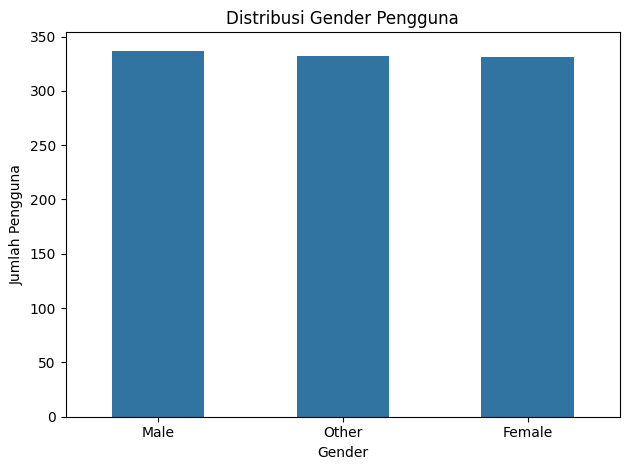

In [39]:
countplot_2(data=users, x='gender', title='Distribusi Gender Pengguna', xlabel='Gender', ylabel='Jumlah Pengguna', rotation=0)

Dari gambar diatas dapat diketahui distribusi gender pengguna.

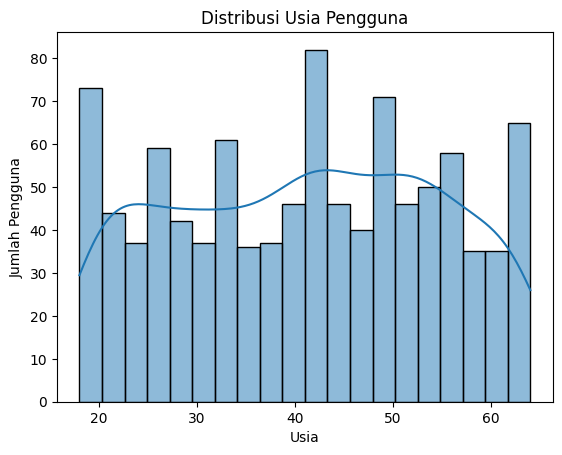

In [40]:
sns.histplot(data=users, x='age', bins=20, kde=True)
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.show()

Dari gambar diatas dapat diketahui distribusi usia pengguna.

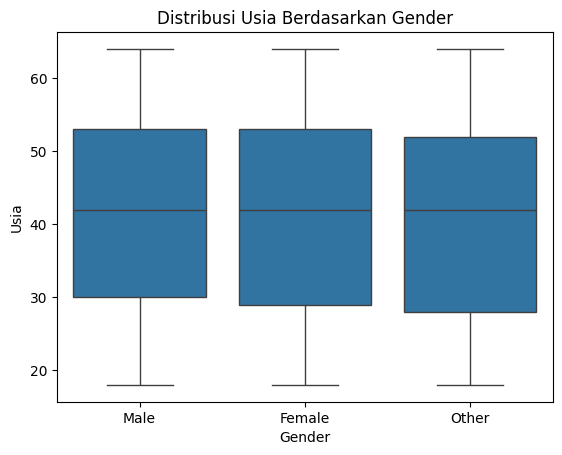

In [41]:
sns.boxplot(data=users, x='gender', y='age')
plt.title('Distribusi Usia Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Usia')
plt.show()

Dari gambar diatas dapat diketahui perbandingan usia antar gender.

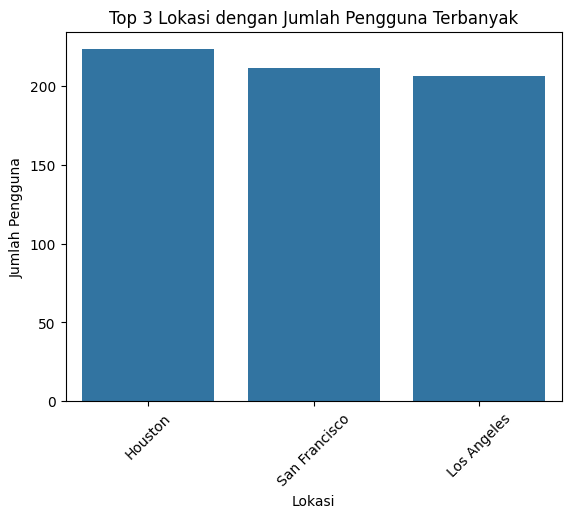

In [42]:
top_locations = users['location'].value_counts().nlargest(3)

sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title('Top 3 Lokasi dengan Jumlah Pengguna Terbanyak')
plt.xlabel('Lokasi')
plt.ylabel('Jumlah Pengguna')
plt.xticks(rotation=45)
plt.show()

Dari gambar diatas kita dapat melihat top lokasi dari user.

# Data Preparation

## Data Preprocessing

### Aggregasi interaksi per produk

In [43]:
interaction_counts = (
    interactions
    .groupby(['product_id', 'interaction_type'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={
        'view': 'total_views',
        'add_to_cart': 'total_add_to_cart',
        'purchase': 'total_purchases'
    })
)

In [44]:
interaction_counts.T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
interaction_type,,,,,,,,,,,,,,,,,,,,,
product_id,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
total_add_to_cart,2,1,2,2,3,0,1,3,0,2,...,2,3,2,2,0,3,2,3,0,3
total_purchases,1,3,0,0,1,0,2,2,1,2,...,0,1,2,0,1,2,0,2,1,1
total_views,6,4,2,5,2,6,5,9,11,8,...,5,7,5,4,6,4,8,7,5,5


Kode ini menghasilkan sebuah tabel baru (interaction_counts) yang menampilkan jumlah total interaksi per produk.

### Aggregasi ulasan per produk

In [45]:
product_reviews = (
    reviews
    .groupby('product_id')
    .agg({
        'rating': 'mean',
        'review_text': lambda x: ' '.join(x)
    })
    .reset_index()
    .rename(columns={'review_text': 'all_reviews'})
)

In [46]:
product_reviews.T

,0,1,2,3,4,5,6,7,8,9,...,485,486,487,488,489,490,491,492,493,494
product_id,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
rating,3.5,2.4,2.0,2.2,4.0,1.5,3.4,2.833333,2.0,3.5,...,3.0,2.75,1.8,3.4,2.285714,2.5,4.0,3.833333,2.714286,3.333333
all_reviews,Not worth the price. Poor quality. Satisfied w...,Not worth the price. Not worth the price. Grea...,Great product!,Highly recommended! Great product! Not worth t...,Great product! Great product!,Not worth the price. Not worth the price.,Poor quality. Poor quality. Great product! Not...,Satisfied with the purchase. Poor quality. Hig...,Satisfied with the purchase. Highly recommende...,Satisfied with the purchase. Poor quality. Not...,...,Highly recommended! Poor quality.,Poor quality. Satisfied with the purchase. Gre...,Highly recommended! Great product! Poor qualit...,Highly recommended! Highly recommended! Not wo...,Satisfied with the purchase. Great product! Po...,Poor quality. Poor quality. Satisfied with the...,Great product! Great product!,Great product! Not worth the price. Highly rec...,Satisfied with the purchase. Not worth the pri...,Highly recommended! Highly recommended! Great ...


Pada tahap ini kita menambahkan rating dan reviews. Kode diatas membuat ringkasan ulasan untuk setiap produk berdasarkan dataset reviews.

### Gabungkan semua data dengan produk sebagai basis

In [47]:
merged_products = (
    products
    .merge(interaction_counts, on='product_id', how='left')
    .merge(product_reviews, on='product_id', how='left')
)

In [48]:
merged_products.T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
product_id,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
category,Home & Kitchen,Clothing,Sports,Electronics,Beauty,Books,Home & Kitchen,Clothing,Electronics,Books,...,Books,Toys,Sports,Home & Kitchen,Clothing,Home & Kitchen,Electronics,Electronics,Beauty,Beauty
price,305.4,80.03,20.31,485.52,387.9,490.15,241.55,268.47,88.33,127.22,...,67.05,171.8,499.77,205.85,114.14,382.43,273.52,79.05,193.44,210.16
brand,BrandB,BrandB,BrandC,BrandB,BrandA,BrandA,BrandC,BrandB,BrandA,BrandA,...,BrandA,BrandD,BrandD,BrandB,BrandE,BrandA,BrandD,BrandA,BrandB,BrandB
total_add_to_cart,2,1,2,2,3,0,1,3,0,2,...,2,3,2,2,0,3,2,3,0,3
total_purchases,1,3,0,0,1,0,2,2,1,2,...,0,1,2,0,1,2,0,2,1,1
total_views,6,4,2,5,2,6,5,9,11,8,...,5,7,5,4,6,4,8,7,5,5
rating,3.5,2.4,2.0,2.2,4.0,1.5,3.4,2.833333,2.0,3.5,...,3.0,2.75,1.8,3.4,2.285714,2.5,4.0,3.833333,2.714286,3.333333
all_reviews,Not worth the price. Poor quality. Satisfied w...,Not worth the price. Not worth the price. Grea...,Great product!,Highly recommended! Great product! Not worth t...,Great product! Great product!,Not worth the price. Not worth the price.,Poor quality. Poor quality. Great product! Not...,Satisfied with the purchase. Poor quality. Hig...,Satisfied with the purchase. Highly recommende...,Satisfied with the purchase. Poor quality. Not...,...,Highly recommended! Poor quality.,Poor quality. Satisfied with the purchase. Gre...,Highly recommended! Great product! Poor qualit...,Highly recommended! Highly recommended! Not wo...,Satisfied with the purchase. Great product! Po...,Poor quality. Poor quality. Satisfied with the...,Great product! Great product!,Great product! Not worth the price. Highly rec...,Satisfied with the purchase. Not worth the pri...,Highly recommended! Highly recommended! Great ...


Pada tahap ini kita menggabungkan dua data yang telah kita gabungkan sebelumnya menjadi kesatuan data seperti diatas.

### Validasi Data Preprocessing

In [49]:
merged_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         500 non-null    int64  
 1   category           500 non-null    object 
 2   price              500 non-null    float64
 3   brand              500 non-null    object 
 4   total_add_to_cart  500 non-null    int64  
 5   total_purchases    500 non-null    int64  
 6   total_views        500 non-null    int64  
 7   rating             495 non-null    float64
 8   all_reviews        495 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 35.3+ KB


In [50]:
merged_products.isnull().sum()

,0
product_id,0
category,0
price,0
brand,0
total_add_to_cart,0
total_purchases,0
total_views,0
rating,5
all_reviews,5


Setelah kita cek, ternyata terdapat missing values, karena jumlahnya tidak banyak hanya 1% dari jumlah data maka akan kita tangani dengan cara fill mean untuk rating dan fill " " string kosong untuk all_reviews.

## Penanganan Missing Values

In [51]:
merged_products.isnull().sum()

,0
product_id,0
category,0
price,0
brand,0
total_add_to_cart,0
total_purchases,0
total_views,0
rating,5
all_reviews,5


### Isi rating dengan rata-rata

In [52]:
merged_products['rating'] = merged_products['rating'].fillna(merged_products['rating'].mean())

### Isi all_reviews dengan string kosong

In [53]:
merged_products['all_reviews'] = merged_products['all_reviews'].fillna('')

### Validasi

In [54]:
merged_products.isnull().sum()

,0
product_id,0
category,0
price,0
brand,0
total_add_to_cart,0
total_purchases,0
total_views,0
rating,0
all_reviews,0


Diatas adalah tahapan penanganan mising values.

##  Encoding Fitur Kategorikal

### Konversi kolom category dan brand ke bentuk numerik dengan One-Hot Encoding

In [55]:
# Inisialisasi encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(merged_products[['category', 'brand']])

# Buat DataFrame hasil encoding
encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(['category', 'brand'])
)

# Gabungkan dengan data utama
merged_products = pd.concat([merged_products, encoded_df], axis=1)

# Hapus kolom asli kategorikal
merged_products.drop(['category', 'brand'], axis=1, inplace=True)

Melakukan encoding pada fitur kategorikal, yaitu category dan brand.

## Text Processing untuk Ulasan

In [56]:
# Inisialisasi TF-IDF
tfidf = TfidfVectorizer(max_features=50)  # Ambil 50 fitur utama
review_vectors = tfidf.fit_transform(merged_products['all_reviews'])

# Konversi ke DataFrame
review_df = pd.DataFrame(
    review_vectors.toarray(),
    columns=[f"review_{feature}" for feature in tfidf.get_feature_names_out()]
)

# Gabungkan dengan data produk
merged_products = pd.concat([merged_products, review_df], axis=1)

# Hapus kolom teks asli
merged_products.drop('all_reviews', axis=1, inplace=True)

Pada tahap diatas kita melakukan ekstraksi fitur pada text ulasan menggunakan TF-IDF.

## Normalisasi Fitur Numerik

In [57]:
# Daftar fitur numerik
numerical_features = ['price', 'total_views', 'total_add_to_cart', 'total_purchases', 'rating']

# Normalisasi
scaler = StandardScaler()
merged_products[numerical_features] = scaler.fit_transform(merged_products[numerical_features])

Pada tahap diatas kita melakukan normalisasi pada fitur numerik menggunakan StandardScaler agar semua fitur memiliki skala yang seimbang.

## Seleksi Fitur Final

In [58]:
final_columns = [
    'product_id',
    *encoder.get_feature_names_out(['category', 'brand']),  # Fitur one-hot encoding
    *numerical_features,                                    # Fitur numerik ternormalisasi
    *review_df.columns                                       # Fitur TF-IDF
]

# Subset data
final_data = merged_products[final_columns]

Pada tahap diatas kita memilih kolom yang akan digunakan untuk pemodelan.

## Validasi Data

In [59]:
final_data.head().T

,0,1,2,3,4
product_id,1.000000,2.000000,3.000000,4.000000,5.000000
category_Beauty,0.000000,0.000000,0.000000,0.000000,1.000000
category_Books,0.000000,0.000000,0.000000,0.000000,0.000000
category_Clothing,0.000000,1.000000,0.000000,0.000000,0.000000
category_Electronics,0.000000,0.000000,0.000000,1.000000,0.000000
category_Home & Kitchen,1.000000,0.000000,0.000000,0.000000,0.000000
category_Sports,0.000000,0.000000,1.000000,0.000000,0.000000
category_Toys,0.000000,0.000000,0.000000,0.000000,0.000000
brand_BrandA,0.000000,0.000000,0.000000,0.000000,1.000000
brand_BrandB,1.000000,1.000000,0.000000,1.000000,0.000000


In [60]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_id               500 non-null    int64  
 1   category_Beauty          500 non-null    float64
 2   category_Books           500 non-null    float64
 3   category_Clothing        500 non-null    float64
 4   category_Electronics     500 non-null    float64
 5   category_Home & Kitchen  500 non-null    float64
 6   category_Sports          500 non-null    float64
 7   category_Toys            500 non-null    float64
 8   brand_BrandA             500 non-null    float64
 9   brand_BrandB             500 non-null    float64
 10  brand_BrandC             500 non-null    float64
 11  brand_BrandD             500 non-null    float64
 12  brand_BrandE             500 non-null    float64
 13  price                    500 non-null    float64
 14  total_views              5

In [61]:
final_data.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,500.0,2.505000e+02,144.481833,1.000000,125.750000,250.500000,375.250000,500.000000
category_Beauty,500.0,1.440000e-01,0.351441,0.000000,0.000000,0.000000,0.000000,1.000000
category_Books,500.0,1.600000e-01,0.366973,0.000000,0.000000,0.000000,0.000000,1.000000
category_Clothing,500.0,1.060000e-01,0.308146,0.000000,0.000000,0.000000,0.000000,1.000000
category_Electronics,500.0,1.620000e-01,0.368820,0.000000,0.000000,0.000000,0.000000,1.000000
category_Home & Kitchen,500.0,1.520000e-01,0.359380,0.000000,0.000000,0.000000,0.000000,1.000000
category_Sports,500.0,1.460000e-01,0.353460,0.000000,0.000000,0.000000,0.000000,1.000000
category_Toys,500.0,1.300000e-01,0.336640,0.000000,0.000000,0.000000,0.000000,1.000000
brand_BrandA,500.0,2.420000e-01,0.428723,0.000000,0.000000,0.000000,0.000000,1.000000
brand_BrandB,500.0,1.940000e-01,0.395825,0.000000,0.000000,0.000000,0.000000,1.000000


Kode diatas berguna untuk memvalidasi bentuk data akhir yang akan kita gunakan untuk tahapan pemodelan.

# Model Development menggunakan Content-Based Filtering

## Hitung Similarity Antar Produk

In [62]:
# Hapus kolom product_id untuk membuat matriks fitur
item_features = final_data.drop('product_id', axis=1)
similarity_matrix = cosine_similarity(item_features)
print(similarity_matrix.shape)

(500, 500)


Tahapan ini bertujuan untuk menghitung seberapa mirip satu produk dengan produk lainnya berdasarkan fitur-fitur selain product_id.

### Visualisasi Similarity Matrix

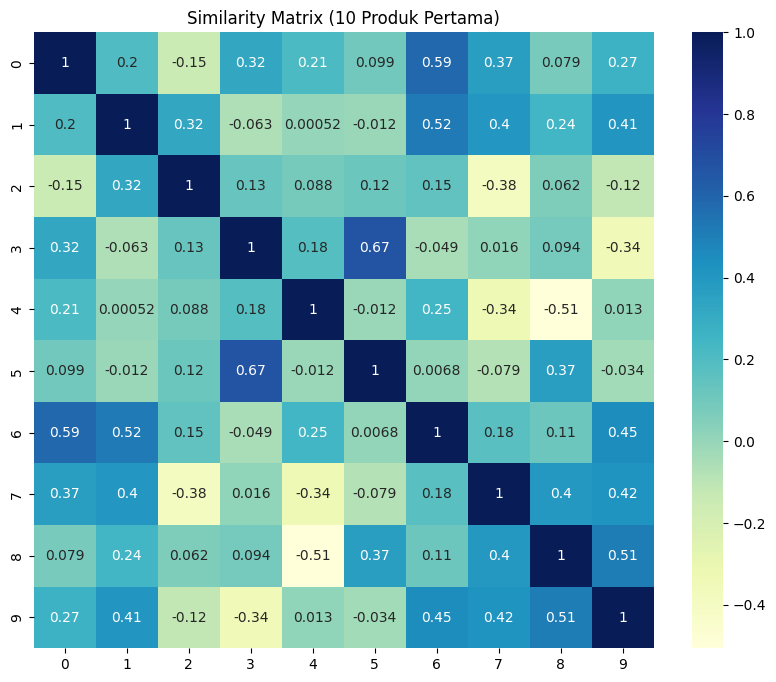

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:10, :10], annot=True, cmap="YlGnBu")
plt.title("Similarity Matrix (10 Produk Pertama)")
plt.show()

Gambar diatas menunjukkan korelasi antar 10 produk pertama.

## Fungsi Rekomendasi Produk

### Fungsi untuk Mendapatkan Rekomendasi

In [64]:
def get_product_recommendations(product_id, n=5):
    try:
        # Cari indeks produk
        product_index = final_data[final_data['product_id'] == product_id].index[0]

        # Ambil similarity scores untuk produk ini
        similar_scores = list(enumerate(similarity_matrix[product_index]))

        # Urutkan berdasarkan similarity score
        sorted_similar = sorted(similar_scores, key=lambda x: x[1], reverse=True)

        # Ambil top-n rekomendasi (exclude produk itu sendiri)
        top_products = sorted_similar[1:n+1]

        # Dapatkan product_id dari rekomendasi
        product_indices = [i[0] for i in top_products]
        recommended_products = final_data.iloc[product_indices]['product_id'].tolist()

        return recommended_products

    except IndexError:
        return "Product ID tidak ditemukan."

Fungsi get_product_recommendations digunakan untuk memberikan rekomendasi produk yang mirip berdasarkan skor kemiripan (cosine similarity). Fungsi ini mencari produk yang paling mirip dengan product_id yang diberikan, menyusun daftarnya berdasarkan skor tertinggi, lalu mengembalikan ID dari beberapa produk teratas yang paling relevan (kecuali dirinya sendiri). Jika product_id tidak ditemukan, fungsi akan mengembalikan pesan error.

### Contoh Penggunaan

In [65]:
product_id = 1

# Dapatkan rekomendasi
recommendations = get_product_recommendations(product_id, n=3)

# Cetak hasil
print(f"Rekomendasi untuk Produk ID {product_id}: {recommendations}")

Rekomendasi untuk Produk ID 1: [256, 494, 27]


In [66]:
products = pd.read_csv("products.csv")
products[products["product_id"] == product_id].T

,0
product_id,1
category,Home & Kitchen
price,305.4
brand,BrandB


In [67]:
recommended_products = products[products["product_id"].isin(recommendations)]
print(f"\nDetail Rekomendasi untuk Produk ID {product_id}:")
recommended_products[["product_id", "category", "price", "brand"]].T


Detail Rekomendasi untuk Produk ID 1:


,26,255,493
product_id,27,256,494
category,Home & Kitchen,Home & Kitchen,Home & Kitchen
price,392.28,369.42,205.85
brand,BrandB,BrandB,BrandB


Diatas adalah contoh penggunaannya.

Tahapan ini melakukan:
- mengambil rekomendasi berbasis produk tertentu
- menampilkan produk tersebut
- menampilkan detail produk-produk yang direkomendasikan

## Evaluasi

### Persiapan Data Evaluasi

#### Split Data Interaksi (Training & Test)

In [68]:
train_interactions, test_interactions = train_test_split(
    interactions,
    test_size=0.2,
    stratify=interactions['interaction_type'],
    random_state=42
)

Kode diatas berfungsi untuk membagi data menjadi traning dan testing dengan proporsi 80:20 dan menggunakan stratift interaction type yang berarti data akan dibagi dengan mempertahankan proporsi masing-masing jenis interaksi.

#### Ground Truth

In [69]:
# Ambil produk yang dibeli di data test
ground_truth = (
    test_interactions[test_interactions['interaction_type'] == 'purchase']
    .groupby('product_id')['user_id']
    .apply(list)
    .to_dict()
)

Kode ini mengambil daftar user yang membeli setiap produk di data testing, lalu menyimpannya dalam format dictionary.

### Hitung Coverage

In [70]:
def calculate_coverage(recommended_products, total_products):
    unique_recommended = len(set(recommended_products))
    return unique_recommended / total_products

Fungsi ini digunakan untuk menghitung coverage atau cakupan dari produk yang direkomendasikan, yang mengukur seberapa banyak produk yang direkomendasikan mencakup keseluruhan produk yang ada.

In [71]:
all_recommended = []
for product_id in ground_truth.keys():
    all_recommended.extend(get_product_recommendations(product_id, n=10))

coverage = calculate_coverage(all_recommended, len(products))
print(f"Coverage: {coverage:.2f}")

Coverage: 0.70


Kode ini digunakan untuk menghitung coverage dari sistem rekomendasi berdasarkan produk yang direkomendasikan.

### Hitung Diversity

In [72]:
def calculate_diversity(recommended_products, final_data):
    # Ambil fitur dari produk yang direkomendasikan (termasuk product_id)
    features_with_id = final_data[final_data['product_id'].isin(recommended_products)]

    # Drop kolom product_id untuk perhitungan similarity
    features = features_with_id.drop('product_id', axis=1)

    # Hitung similarity antar rekomendasi
    similarity = cosine_similarity(features)
    np.fill_diagonal(similarity, 0)  # Abaikan similarity dengan diri sendiri

    # Hitung diversity sebagai 1 - rata-rata similarity
    diversity = 1 - np.mean(similarity)
    return diversity

Fungsi ini digunakan untuk menghitung diversity dari produk yang direkomendasikan. Diversity mengukur variasi atau keragaman dalam produk yang direkomendasikan, dengan tujuan untuk menghindari rekomendasi yang terlalu mirip satu sama lain.

In [73]:
diversity = calculate_diversity(all_recommended, final_data)
print(f"Diversity: {diversity:.2f}")

Diversity: 0.88


Hasil diversity dapat dilihat dari output diatas. Ini berarti menunjukkan bahwa produk yang direkomendasikan sangat beragam, dengan nilai lebih tinggi menunjukkan keragaman yang lebih baik.

# Model Development menggunakan Collaborative-Filtering

## Data Understanding

In [74]:
df = pd.read_csv("interactions.csv")
df

,user_id,product_id,interaction_type,timestamp
0,869,22,purchase,2024-01-01 00:00:00
1,368,463,view,2024-01-01 01:00:00
2,429,269,view,2024-01-01 02:00:00
3,830,412,view,2024-01-01 03:00:00
4,807,161,add_to_cart,2024-01-01 04:00:00
...,...,...,...,...
4995,885,437,view,2024-07-27 03:00:00
4996,965,8,view,2024-07-27 04:00:00
4997,689,409,purchase,2024-07-27 05:00:00
4998,282,424,view,2024-07-27 06:00:00


Kode diatas kita Meload data reviews dan menyimpannya dalam variabel df, pada tahapan sebelumnya kita juga telah mengeksplorasinya.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           5000 non-null   int64 
 1   product_id        5000 non-null   int64 
 2   interaction_type  5000 non-null   object
 3   timestamp         5000 non-null   object
dtypes: int64(2), object(2)
memory usage: 156.4+ KB


Data review memiliki 5000 baris dan 4 kolom.

## Data Preparation

### Weight map pada interaction_type

In [76]:
weight_map = {
    'view': 1,
    'add_to_cart': 3,
    'purchase': 5
}

df = df.copy()
df['weight'] = df['interaction_type'].map(weight_map)

Kode ini digunakan untuk memberikan berat (weight) pada setiap jenis interaksi pengguna berdasarkan tipe interaksi (seperti "view", "add_to_cart", "purchase"). Berat ini kemudian ditambahkan sebagai kolom baru dalam dataframe.

### Mengubah timestamp ke datetime

In [77]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

Mengubah tipe data timestamp, disini kolom timestamp tidak kita gunakan.

### Aggregate per user-product

In [78]:
agg = (
    df
    .groupby(['user_id', 'product_id'])['weight']
    .sum()
    .reset_index()
)

Kode ini digunakan untuk mengagregasi data berdasarkan kombinasi user_id dan product_id, kemudian menjumlahkan nilai kolom weight untuk setiap kombinasi tersebut. Hasilnya adalah dataframe yang menunjukkan total bobot (weight) yang diberikan oleh setiap pengguna terhadap produk tertentu.

### Binarisasi: interaction=1 jika total weight >= threshold, else 0

In [79]:
threshold = 3
agg['interaction'] = (agg['weight'] >= threshold).astype(int)

Kode ini digunakan untuk menambahkan kolom baru dalam dataframe agg yang menunjukkan apakah total bobot interaksi untuk setiap kombinasi user_id dan product_id melebihi batas ambang (threshold) tertentu, dalam hal ini nilai threshold adalah 3.

### Encode user_id & product_id ke idx 0..N-1

In [80]:
user_ids    = agg['user_id'].unique()
product_ids = agg['product_id'].unique()
user_encoder    = {u:i for i, u in enumerate(user_ids)}
product_encoder = {p:i for i, p in enumerate(product_ids)}

agg['user_idx']    = agg['user_id'].map(user_encoder)
agg['product_idx'] = agg['product_id'].map(product_encoder)

num_users    = len(user_encoder)
num_products = len(product_encoder)

Melakukan encoding pada kolom userid dan productid

### Negative sampling (implicit feedback)

In [81]:
N_neg = 3  # misal 3 negative per positive
user_pos = agg[agg['interaction']==1].groupby('user_idx')['product_idx'].apply(set).to_dict()
all_prods = set(range(num_products))

neg_samples = []
for u, pos_set in user_pos.items():
    # ambil negatif secara acak
    negs = np.random.choice(
        list(all_prods - pos_set),
        size=N_neg * len(pos_set),
        replace=True
    )
    neg_samples += [(u, p, 0) for p in negs]

neg_df = pd.DataFrame(neg_samples, columns=['user_idx','product_idx','interaction'])
pos_df = agg[['user_idx','product_idx','interaction']]

data = pd.concat([pos_df, neg_df], ignore_index=True).sample(frac=1, random_state=42)

Melakukan negative sampling. Kode ini digunakan untuk menghasilkan sampel negatif (non-interaksi) untuk setiap pengguna yang memiliki interaksi positif dengan produk. Kemudian, kode ini menggabungkan interaksi positif dan negatif ke dalam satu dataset yang dapat digunakan untuk pelatihan model rekomendasi, seperti untuk binary classification (apakah pengguna akan berinteraksi dengan produk atau tidak).

### Validasi data

In [82]:
data

,user_idx,product_idx,interaction
3859,779,207,0
1710,339,94,0
7711,451,178,0
7149,353,494,0
8744,611,311,0
...,...,...,...
5734,130,417,0
5191,44,231,0
5390,74,121,0
860,174,387,0


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10888 entries, 3859 to 7270
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_idx     10888 non-null  int64
 1   product_idx  10888 non-null  int64
 2   interaction  10888 non-null  int64
dtypes: int64(3)
memory usage: 340.2 KB


In [84]:
# Mendapatkan jumlah user & product
print(num_users)
print(num_products)

# Mengubah rating menjadi nilai float
data['interaction'] = data['interaction'].values.astype(np.float32)

# Nilai minimum rating
min_interaction = min(data['interaction'])

# Nilai maksimal rating
max_interaction = max(data['interaction'])

print('Number of User: {}, Number of Product: {}, Min Interaction: {}, Max Interaction: {}'.format(
    num_users, num_products, min_interaction, max_interaction
))

996
500
Number of User: 996, Number of Product: 500, Min Interaction: 0.0, Max Interaction: 1.0


Pada tahapan diatas dapat kita lihat data yang akan kita gunakan.

### Split Data

In [85]:
# Mengacak dataset
data = data.sample(frac=1, random_state=42)
data

,user_idx,product_idx,interaction
5221,50,153,0.0
1883,375,36,0.0
5835,152,261,0.0
4307,867,160,1.0
7788,467,345,0.0
...,...,...,...
5564,104,55,0.0
10384,904,106,0.0
143,29,126,0.0
8112,509,263,0.0


Mengacak data agar distribusinya menjadi random.

In [86]:
# Membuat variabel x untuk mencocokkan data user dan product menjadi satu value
x = data[['user_idx', 'product_idx']].values

# Membuat variabel y untuk membuat rating dari hasil
y = data['interaction'].apply(lambda x: (x - min_interaction) / (max_interaction - min_interaction)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 50 153]
 [375  36]
 [152 261]
 ...
 [ 29 126]
 [509 263]
 [761 400]] [0. 0. 0. ... 0. 0. 0.]


Melakukan Splitting data untuk train dan validation

## Proses Training

In [87]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_products, embedding_size=32, dropout_rate=0.3, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Embedding layer with regularization
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='glorot_uniform',  # Xavier initialization for sigmoid activations
            embeddings_regularizer=regularizers.l2(1e-4)
        )
        self.user_bias = layers.Embedding(num_users, 1, embeddings_initializer='zeros')  # User bias

        self.product_embedding = layers.Embedding(
            input_dim=num_products,
            output_dim=embedding_size,
            embeddings_initializer='glorot_uniform',
            embeddings_regularizer=regularizers.l2(1e-4)
        )
        self.product_bias = layers.Embedding(num_products, 1, embeddings_initializer='zeros')  # Product bias

        # Dropout layer for regularization
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs):
        # inputs shape: (batch_size, 2) → [user_id, product_id]
        user_id, product_id = inputs[:, 0], inputs[:, 1]

        # Get embeddings + apply dropout for regularization
        user_vec = self.user_embedding(user_id)
        user_vec = self.dropout(user_vec)
        user_b = self.user_bias(user_id)

        prod_vec = self.product_embedding(product_id)
        prod_vec = self.dropout(prod_vec)
        prod_b = self.product_bias(product_id)

        # Compute the dot product of the embeddings + biases
        dot_product = tf.reduce_sum(user_vec * prod_vec, axis=1, keepdims=True)
        x = dot_product + user_b + prod_b

        # Sigmoid activation for the final prediction
        return tf.nn.sigmoid(x)

Membuat class RecommenderNet dengan keras Model class. Kode ini mendefinisikan sebuah model rekomendasi berbasis Neural Collaborative Filtering (NCF) yang menggunakan embedding untuk representasi pengguna dan produk, serta bias untuk setiap pengguna dan produk. Model ini dirancang untuk memprediksi apakah seorang pengguna akan memberikan interaksi (misalnya, pembelian) terhadap suatu produk.

In [88]:
# Model Compile
model = RecommenderNet(
    num_users=num_users,
    num_products=num_products,
    embedding_size=64,
    dropout_rate=0.5
)

# Compile Model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]  # Added accuracy metric
)

Kode diatas berguna untuk mendefinisikan model neural network untuk sistem rekomendasi yang memanfaatkan embeddings untuk pengguna dan produk, dan kemudian mengompilasi model dengan pengaturan yang sesuai untuk training.

In [89]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

pada kode diatas kita membuat dua callback yaitu:
- EarlyStopping: Melakukan penghentian pelatihan jika val_loss tidak membaik selama 5 epoch berturut-turut.
- ModelCheckpoint: Menyimpan model terbaik berdasarkan val_loss.
- ReduceLROnPlateau: Mengurangi learning rate ketika val_loss berhenti membaik.

In [90]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/100
32/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7128 - root_mean_squared_error: 0.4996 
Epoch 1: val_loss improved from inf to 0.69974, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7105 - root_mean_squared_error: 0.4993 - val_loss: 0.6997 - val_root_mean_squared_error: 0.4967 - learning_rate: 0.0010
Epoch 2/100
29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6890 - root_mean_squared_error: 0.4914   
Epoch 2: val_loss improved from 0.69974 to 0.69128, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - root_mean_squared_error: 0.4910 - val_loss: 0.6913 - val_root_mean_squared_error: 0.4932 - learning_rate: 0.0010
Epoch 3/100
37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6732 - root_mean_squared_error: 0.4840 
Epoch 3: val_loss improved from 0.69128 to 0.68448, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6726 - root_mean_squared_error: 0.4837 - val_loss: 0.6845

## Mendapatkan Rekomendasi

In [91]:
products = pd.read_csv("products.csv")
df = pd.read_csv('interactions.csv')

# Mengambil sample user
user_id = df.user_id.sample(1).iloc[0]
product_got_interaction = df[df.user_id == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
product_no_interaction= products[~products['product_id'].isin(product_got_interaction.product_id.values)]['product_id']
product_no_interaction = list(
    set(product_no_interaction)
    .intersection(set(product_encoder.keys()))
)

product_no_interaction = [[product_encoder.get(x)] for x in product_no_interaction]
user_enc = user_encoder.get(user_id)
user_product_array = np.hstack(
    ([[user_enc]] * len(product_no_interaction), product_no_interaction)
)

Kode diatas berfungsi untuk mempersiapkan data input guna memberi rekomendasi produk ke seorang user yang belum pernah berinteraksi dengan produk-produk tersebut.

In [92]:
interactions = model.predict(user_product_array).flatten()

top_interactions_indices = interactions.argsort()[-10:][::-1]
recommended_product_ids = [
    product_encoder.get(product_no_interaction[x][0]) for x in top_interactions_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Product with high interactions from user')
print('----' * 8)

top_product_user = (
    product_got_interaction.sort_values(
        by = 'interaction_type',
        ascending=False
    )
    .head(5)
    .product_id.values
)

product_df_rows = products[products['product_id'].isin(top_product_user)]
for row in product_df_rows.itertuples():
    print(row.product_id, ':', row.category, ':', row.brand)

print('----' * 8)
print('Top 10 product recommendation')
print('----' * 8)

recommended_product = products[products['product_id'].isin(recommended_product_ids)]
for row in recommended_product.itertuples():
    print(row.product_id, ':', row.category, ':', row.brand)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Showing recommendations for users: 894
Product with high interactions from user
--------------------------------
21 : Books : BrandD
39 : Electronics : BrandE
80 : Sports : BrandA
194 : Home & Kitchen : BrandD
223 : Sports : BrandD
--------------------------------
Top 10 product recommendation
--------------------------------
1 : Home & Kitchen : BrandB
61 : Electronics : BrandD
196 : Sports : BrandA
206 : Toys : BrandC
263 : Electronics : BrandB
282 : Beauty : BrandB
374 : Books : BrandC
460 : Clothing : BrandA
467 : Home & Kitchen : BrandB
471 : Sports : BrandD


Output diatas adalah salah satu penggunaan collaborative filtering. Perhatikanlah, beberapa produk rekomendasi menyediakan kategori  yang sesuai dengan interactions user.

## Evaluasi

### Plot Training-Validation RMSE

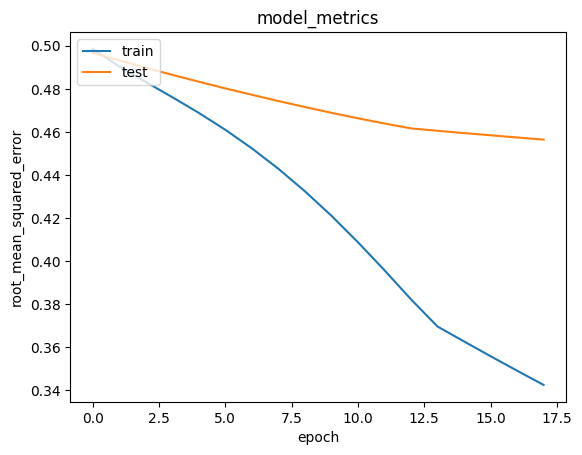

In [93]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dari gambar diatas dapat kita lihat Root Mean Squared Error (RMSE) antara training dan validation selama proses training. Model menunjukkan tanda-tanda overfitting, di mana loss pada training set terus menurun tetapi val_loss mulai stagnan.

### Evaluasi RMSE pada Validation Set

In [95]:
val_loss, val_rmse = model.evaluate(x_val, y_val, batch_size=64)
print(f"Validation Loss: {val_loss:.4f}, Validation RMSE: {val_rmse:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6692 - root_mean_squared_error: 0.4745  
Validation Loss: 0.6689, Validation RMSE: 0.4743


Model menghasilkan RMSE 0.4743 dan loss 0.6689. Nilai RMSE ~0.47 (dalam skala 0-1) menunjukkan kesalahan prediksi cukup signifikan.

### Evaluasi MAE pada Validation set

In [101]:
y_pred = model.predict(x_val).flatten()
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE: {mae:.4f}")

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
MAE: 0.4726


MAE 0.4726 (hampir sama dengan RMSE) mengindikasikan kesalahan prediksi cenderung konsisten tanpa banyak outlier.